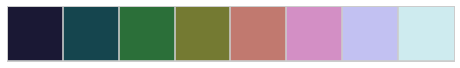

In [1]:
# Imports
%matplotlib inline
import pandas as pd
from pandas.io.json import json_normalize
import json
import numpy as np
import datetime
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence, partial_dependence
import xgboost as xgb
from xgboost import plot_importance

# Setup pandas
pd.options.display.max_rows = 400
pd.options.display.max_columns = None

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")
palette = sns.color_palette("cubehelix", 8)
sns.set_palette(palette)
sns.palplot(palette)


# Part 1: Exploratory Analysis of Logins

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
# Read logins.json to pandas dataframe
dfi = pd.read_json('logins.json')

# Get aquainted wiht the df
display(dfi.head())
display(dfi.describe())
dfi.info()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.4 MB


In [3]:
# Create column that rounds datetimes down to the last quarter hour
dfi['qtr_hr'] = dfi.login_time.apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour,15*(dt.minute // 15)))
dfi.head()

,login_time,qtr_hr
0,1970-01-01 20:13:18,1970-01-01 20:00:00
1,1970-01-01 20:16:10,1970-01-01 20:15:00
2,1970-01-01 20:16:37,1970-01-01 20:15:00
3,1970-01-01 20:16:36,1970-01-01 20:15:00
4,1970-01-01 20:26:21,1970-01-01 20:15:00


In [5]:
# Group df by qtr_hr to count the number of logins per qtr_hr and generate df, rename columns accordingly
df = pd.DataFrame(dfi.groupby('qtr_hr')['login_time'].count().reset_index()).rename(index=str, columns={"login_time": "logins"})

# Make the qtr_hr columns the index
df.index = df['qtr_hr']
del df['qtr_hr']

# Resample in 15 min increments to ensure there is a row for every 15 min increment, even if there weren't any logins (fill those with zeros)
df = df.asfreq(freq='15min', fill_value=0)

# Get aquainted with df_agg
display(df.head())
display(df.describe())
display(df.info())

,logins
qtr_hr,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


,logins
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
logins    9788 non-null int64
dtypes: int64(1)
memory usage: 152.9 KB


None

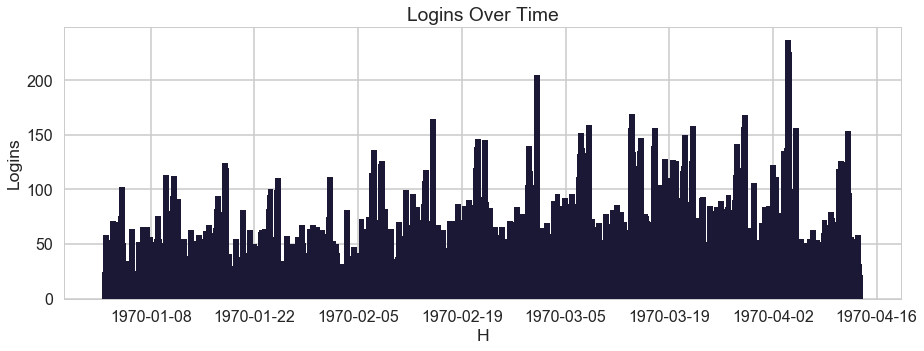

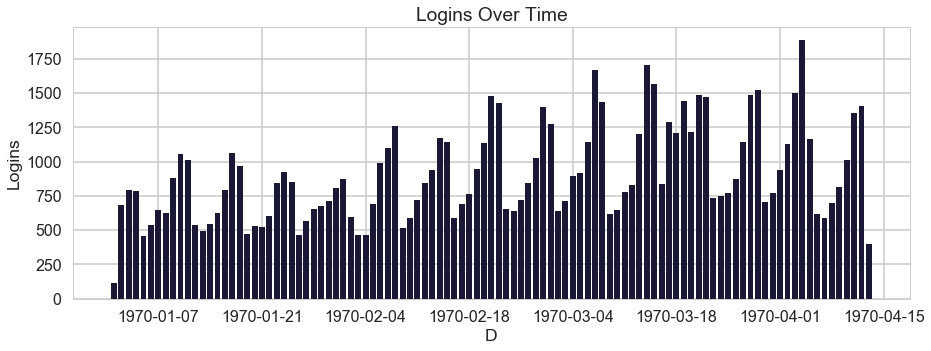

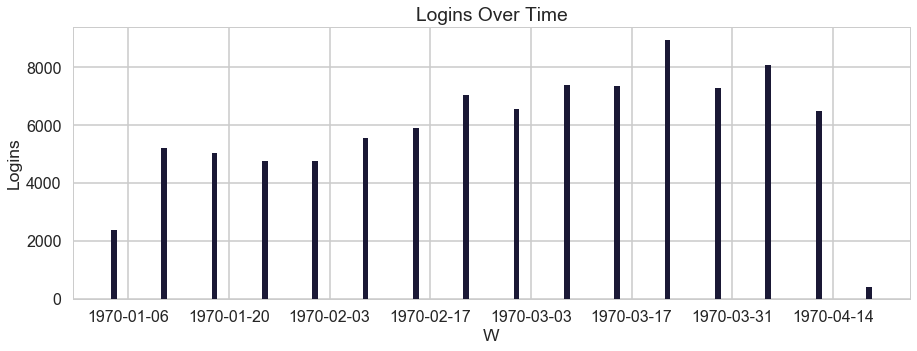

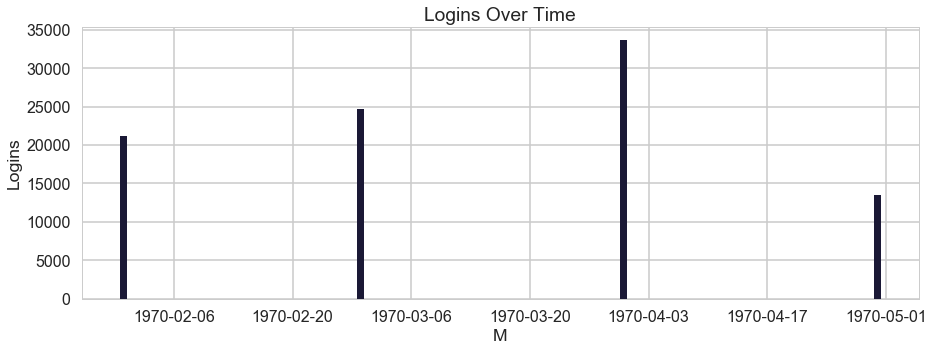

In [6]:
def plot_incr(incr):
    
    # Resample df in the increments of 'incr'
    df_inc = df.resample(incr).sum()

    # Plot volume of logins per increment
    plt.figure(figsize=(15,5))
    plt.bar(df_inc.index, df_inc.logins, data=df_inc)
    plt.title('Logins Over Time')
    plt.ylabel('Logins')
    plt.xlabel(incr)
    plt.show()

# Plot logins in hourly, daily, weekly, and monthly increments
plot_incr('H')
plot_incr('D')
plot_incr('W')
plot_incr('M')

From the weekly plot above, it looks like there is clear periodicity by day of week. In order to further investigate this

In [7]:
# Add columns to represent day of week, day (of month), and hour (of day)
df['dow'] = df.index.dayofweek
df['day'] = df.index.day
df['hour'] = df.index.hour
df.head()

,logins,dow,day,hour
qtr_hr,,,,
1970-01-01 20:00:00,2,3,1,20
1970-01-01 20:15:00,6,3,1,20
1970-01-01 20:30:00,9,3,1,20
1970-01-01 20:45:00,7,3,1,20
1970-01-01 21:00:00,1,3,1,21


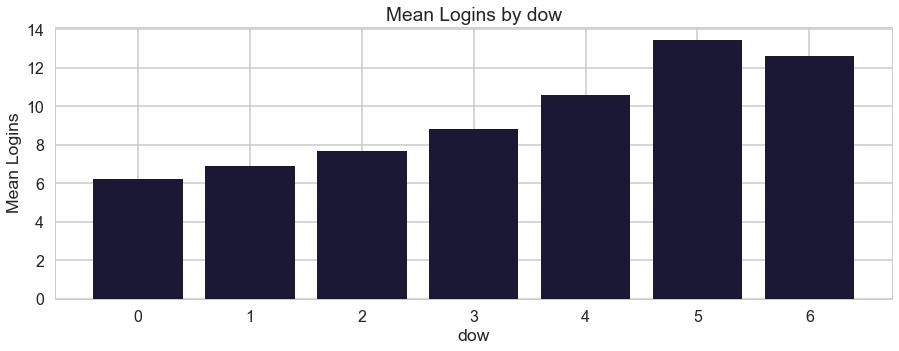

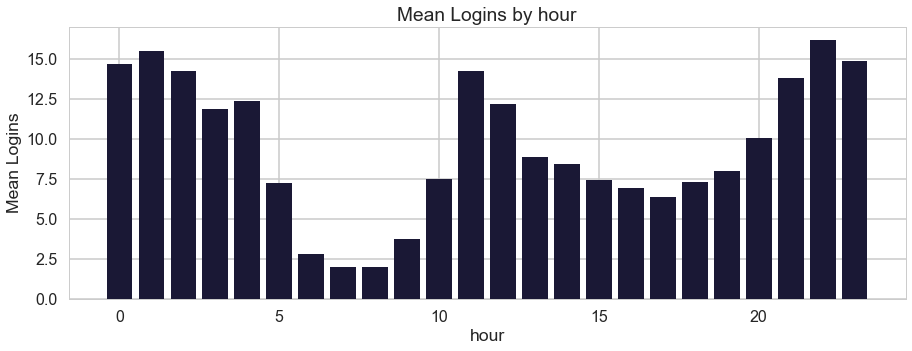

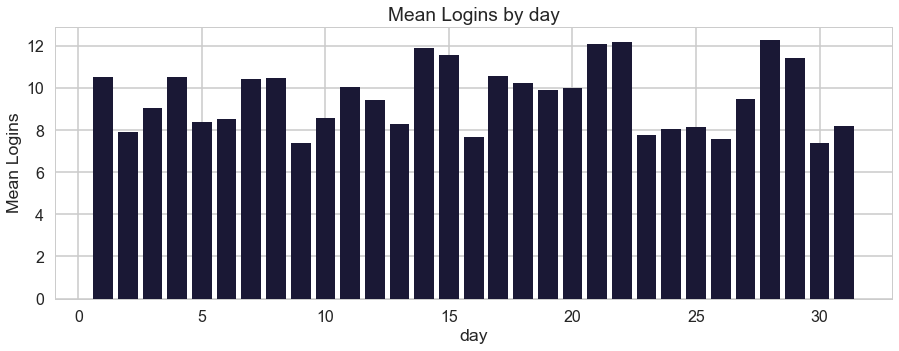

In [8]:
# Function that plots the mean number of logins by feature of interest
def plot_gr(unit):

    # Group df by unit of choice and take the mean
    df_gr = pd.DataFrame(df.groupby(unit)['logins'].mean()).reset_index()

    # Plot mean number of logins
    plt.figure(figsize=(15,5))
    plt.bar(df_gr[unit], df_gr.logins, data=df_gr)
    plt.title('Mean Logins by ' + unit)
    plt.ylabel('Mean Logins')
    plt.xlabel(unit)
    plt.show()

plot_gr('dow')
plot_gr('hour')
plot_gr('day')

From the plots above:
    1. Demand increases by day throughout the weak, peaking on Saturdays.
    2. Within a day, demand tends to be high early in the morning, around lunch, and late at night.
    3. There isn't much of a discernable pattern of demand by day of month.

It could be valuable to see if hourly demand varies by day of week.

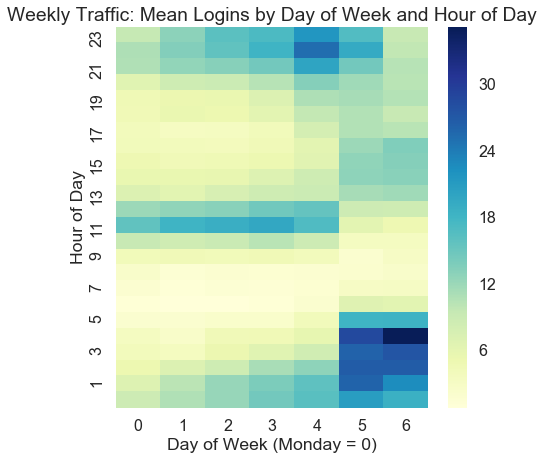

In [634]:
# Create data frame with the mean of logins by day of week and hour of day
df_gr = pd.DataFrame(df.groupby(['dow','hour'])['logins'].mean()).reset_index()

# Pivot data frame so hours is the index and dow's are columns, sort hours descending
df_gr = df_gr.pivot('hour','dow','logins').sort_index(ascending = False )

# Plot heatmap
plt.figure(figsize=(7,7))
ax = sns.heatmap(df_gr, cmap="YlGnBu")
plt.title('Weekly Traffic: Mean Logins by Day of Week and Hour of Day')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week (Monday = 0)')
plt.show()

1. It appears that the time of the week with the highest traffic if Saturday and Sunday very early in the morning.
2. There does seem to be a different pattern of demand on weekdays (with a lunch time and night time peaks) vs. weekends (with very early morning peaks)

# Part 2: Experiment Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs. 
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. How you will implement the experiment? What statistical test(s) you will conduct to verify the significance of the observation? How you would interpret the results and provide recommendations to the city operations team along with any caveats.

### 1. Success Metric

Ultimately you want supply to match demand for both cities, therefore success for this program would be defined by whether or not drivers in the test group are more likely than those in the control group to move from the city with a driver surplus to the city with a driver deficit when there is a mismatch. In a world with surge pricing and where drivers are given estimate in what they might expect to earn in each city on their dashboards, the target metric could be something like the percent of drivers that cross borders for an expected 10% increase in earnings. (We'll call this "cross percent.")

### 2. Experimental Design

Implementation: Assuming drivers do not communicate with each other and their are thousands of active drivers in each city doing tens of thousands of trips a day, I would suggest combining drivers from both cities in the same list and randomly selecting 50% of drivers for the test group, to whom full reimbursement would be given. The other half of drivers would not be aware of what was going on and would be the control group. You would have to let the experiment run for at least a couple weeks, in order to capture the dynamics of the weekly cycles and to aquire enough data for significant results. If a larger portion of drivers in the test group cross borders for the same expected increase in earnings, then you could assume that the reimbursement was helpful in better matching supply and demand. (Although whether or not the scheme was financially beneficial would require additional analysis.)

Statistical tests: The null hypothesis would be that there is no difference in the cross rates between the test and control groups. The alternative would be that there is a difference. With the data in hand, I would check whether or not the the central limit theorem applies and then use a chi square test to evaluate if the null hypothesis should be rejected. To evaluate the applicability of the Central Limit Theorem, I would use the following code. Assume their is a dataframe with a row for each driver each time there was a expected earning differential of greater than 10%. There is a binary column called "cross" indicating whether or not that driver actually crossed the border. There is a column called "group" which indicates whether the drive was in the test or control group

As long as all np's and nq's are greater than 5, the samples are large enough for the central limit theorem to apply and to use the normal approximation. Since the independant variable would also be randomly assigned, the Central Limit Theorem would apply and a two-sample (binomial) proportions test would be appropriate. I would run a Chi Square Test as follows:


If the measured value of the cross rate for the test group was higher than that of the control group and the observed difference was outside the 95% confidence interval and the p-value suggested that there was less than a 5% probability we would see a difference that large if the cross rates for the two groups were truly the same, then the null hypothesis would be rejected. There would be a statistically significant difference between the test and control group's cross rates and because the reimbursement was randomely assigned, would assume the difference was caused by the reimbursement, and that the reimbursement helped equilibrate the markets.

Results and Recommendations: At this point, I would suggest that Ultimate Inc would do a cost benefit analysis as to whether or not full reimbursement was worth the investment. How many more rides (and therefore more revenue and profit) did the company bring in because drivers moved across borders more fluidly and how much did the company have to spend to reimburse drivers? How will increasing availability of drivers impact customer behavior in the long run? After cost-benefit analysis, if this scheme is considered to be worth the cost, I would suggest to move forward with the plan. If it isn't, I would suggest the Ultimate Inc try incentivising drivers to cross markets in other ways (i.e. maybe partial repayment, maybe through gamified incentives, etc.) 

# Part 3: Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).



Data Description
1. city: city this user signed up in
2. phone: primary device for this user
3. signup_date: date of account registration; in the form ‘YYYY MM DD’
4. last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
5. avg_dist: the average distance in miles per trip taken in the first 30 days after signup
6. avg_rating_by_driver: the rider’s average rating over all of their trips
7. avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
8. surge_pct: the percent of trips taken with surge multiplier > 1
9. avg_surge: The average surge multiplier over all of this user’s trips
10. trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
11. ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;FALSE otherwise
12. weekday_pct: the percent of the user’s trips occurring during a weekday

In [9]:
# Open and load json data
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)

# Generate DF
df = pd.DataFrame(data)

# Get aquainted with df
display(df.head())
display(df.describe())
df.info()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Feature Engineering and Data Exploration

In [10]:
# Convert date columns to datetime data type
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
print("dtypes: ",df['last_trip_date'].dtype,",", df['signup_date'].dtype,)

dtypes:  datetime64[ns] , datetime64[ns]


In [11]:
# Create column for how many months out they were active
## add one month after last trip date because considered active if taken ride in past 30 days
df['months_active'] = (((df.last_trip_date - df.signup_date)/np.timedelta64(1, 'M'))+1).apply(np.floor)

# Add binary column that indicates whether or not rider was active 6 months out
df['active_6mos'] = np.where(df['months_active']>=6, 1, 0)

# What percent were "active" for any portion of their 6th month?
print(np.round(np.mean(df['active_6mos'])*100,1),"% of riders were active in their 6th month.")


22.4 % of riders were active in their 6th month.


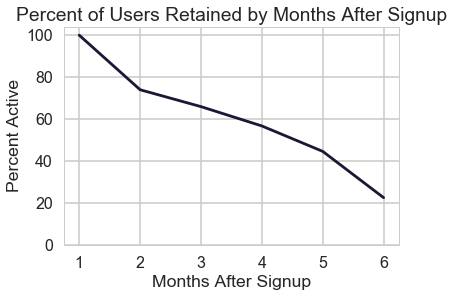

In [13]:
# Create df with % of riders active x months out
df_gr = pd.DataFrame(df.groupby('months_active')['signup_date'].count())
df_gr['signup_date'] = df_gr['signup_date']/len(df)
df_gr['retained'] = (1-df_gr['signup_date'].shift(periods=1).cumsum())
df_gr['retained'] = df_gr['retained'].fillna(1.0)*100

# Plot % of riders active x months out
plt.plot(df_gr.index,df_gr.retained)
plt.title('Percent of Users Retained by Months After Signup')
plt.ylabel('Percent Active')
plt.xlabel('Months After Signup')
plt.ylim(bottom=0)
plt.show()


In [14]:
# Binners are variables that have a higher number of unique values
binners = ['surge_pct','avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','weekday_pct']

# Cats are categorical variables
cats = ['phone','city','ultimate_black_user']

# Function that generates a df of a feature versus the target variable, "active_6mos"
def df_feat(feature):
    dfa = df
    
    # If the feature is a binner
    # Create bins the size that splits the range from the smallest to the 95th percentil into 10 bins
    # Create a colum "feat" that is each value rounded to the nearest bin
    # Else, just use the feature value for the feat column
    if feature in binners:
        bucket_size  = (df[feature].quantile(.95) - np.min(df[feature]))/10
        dfa['feat'] = (dfa[feature]/bucket_size).apply(np.floor)
        dfa['feat'] = dfa['feat']*bucket_size
    else:
        dfa['feat'] = dfa[feature]
    
    # Create a df grouping by feature, with a column for the mean target and the number of observation at each value of feat
    dfa  = dfa.groupby('feat')['active_6mos'].agg(['mean','count']).reset_index()
    dfa['perc'] = dfa['count']*100.0/sum(dfa['count'])
    dfa['mean'] = dfa['mean']*100.0
    
    # If the resulting df is longer than 10 rows, only show the rows that cover the first 95% of the observations
    if len(dfa) > 10:
        dfa = dfa[dfa['perc'].cumsum()<=95]
    else:
        dfa = dfa
    
    # If the feature is a categorical variable, sort by highest mean target value (for easier plotting)
    if feature in cats:
        dfa = dfa.sort_values(by='mean', ascending=False)
    else:
        dfa = dfa
    
    # Return the df
    return dfa

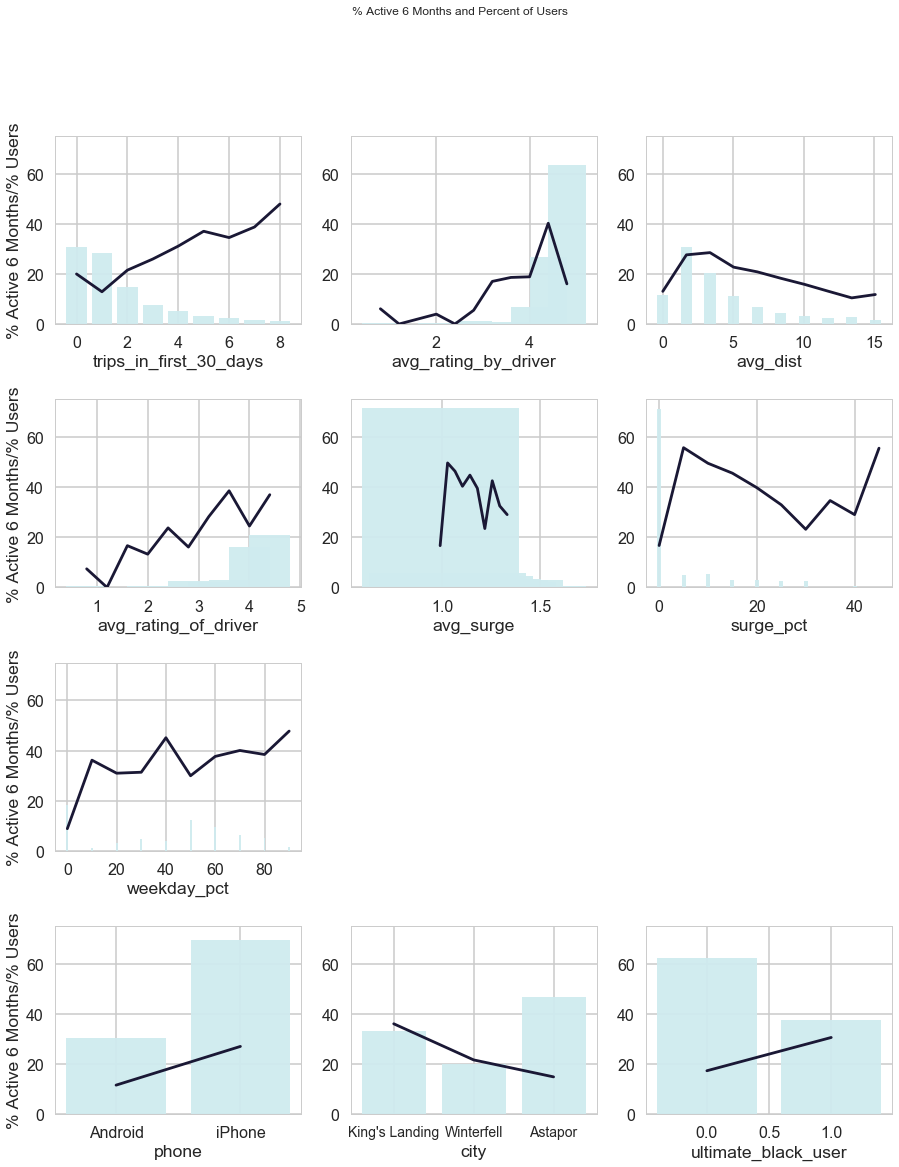

In [17]:
fig = plt.figure(figsize=(15,18))
plt.tight_layout()
fig.suptitle("% Active 6 Months and Percent of Users")
plt.subplots_adjust(hspace = 0.4)

ax1 = plt.subplot(4,3,1)
dfp = df_feat('trips_in_first_30_days')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Active 6 Months/% Users')
plt.xlabel('trips_in_first_30_days')

plt.subplot(4,3,2, sharey=ax1)
dfp = df_feat('avg_rating_by_driver')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('avg_rating_by_driver')

plt.subplot(4,3,3, sharey=ax1)
dfp = df_feat('avg_dist')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('avg_dist')

plt.subplot(4,3,4, sharey=ax1)
dfp = df_feat('avg_rating_of_driver')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Active 6 Months/% Users')
plt.xlabel('avg_rating_of_driver')

plt.subplot(4,3,5, sharey=ax1)
dfp = df_feat('avg_surge')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('avg_surge')

plt.subplot(4,3,6, sharey=ax1)
dfp = df_feat('surge_pct')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('surge_pct')

plt.subplot(4,3,7, sharey=ax1)
dfp = df_feat('weekday_pct')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Active 6 Months/% Users')
plt.xlabel('weekday_pct')

plt.subplot(4,3,10, sharey=ax1)
dfp = df_feat('phone')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.ylabel('% Active 6 Months/% Users')
plt.xlabel('phone')

plt.subplot(4,3,11, sharey=ax1)
dfp = df_feat('city')
plt.plot(range(len(dfp)), dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xticks(range(len(dfp)), dfp['feat'], fontsize=14)
plt.xlabel('city')

plt.subplot(4,3,12, sharey=ax1)
dfp = df_feat('ultimate_black_user')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[7], alpha = .95)
plt.xlabel('ultimate_black_user')


plt.show()

## Data Cleaning

In [18]:
# Observations with missing values for phone (assuming issues with data)
original_len = len(df)
df = df.dropna(axis=0, subset=['phone'])
percent_retained = 1 - ((original_len - len(df))/original_len)
print("Percent of observations retained after dropping nulls:",round(percent_retained*100,1),'%')

Percent of observations retained after dropping nulls: 99.2 %


In [19]:
# How many users are there with an average distance of 0.0 miles?
print("Percent of users with avg_dist of 0.0 miles:", round(len(df[df.avg_dist==0])*100/len(df),1),'%')

Percent of users with avg_dist of 0.0 miles: 0.3 %


While it's strange that users would have have an average trip of 0.0 miles, avg_dist is only presented to the tenth of a mile and it is perceivable that users could have called trips for 0.04 of a mille (that could have been rounded down to 0.0 miles.) Further more, the number of trips in th first months of these groups is pretty small and the percent of users this represents is pretty small. Without further information, it's plausible that this is accurate data, so I am not manipulating these values in anyway.

Assuming that now users with null rating were either not reviewed otr did not give reviews (rather than there being an error with the data,) I am going to generate two columns to represent that information and then fill in the missing values with the for each column.

In [20]:
# Generate columns to indicate when reviews were given/recieved
df['reviewed'] = np.where(df.avg_rating_by_driver.isnull(), 0, 1)
df['gave_review'] = np.where(df.avg_rating_of_driver.isnull(), 0, 1)

# Fill in nans with mean value for that column
df['avg_rating_by_driver'] = np.where(df.avg_rating_by_driver.isnull(),np.mean(df.avg_rating_by_driver) , df.avg_rating_by_driver)
df['avg_rating_of_driver'] = np.where(df.avg_rating_of_driver.isnull(),np.mean(df.avg_rating_of_driver) , df.avg_rating_of_driver)


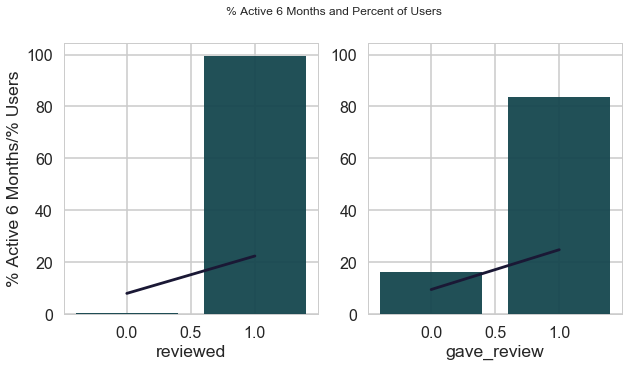

In [21]:
fig = plt.figure(figsize=(10,5))
fig.suptitle("% Active 6 Months and Percent of Users")
plt.subplots_adjust(hspace = 0.4)

ax1 = plt.subplot(1,2,1)
dfp = df_feat('reviewed')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[1], alpha = .95)
plt.ylabel('% Active 6 Months/% Users')
plt.xlabel('reviewed')

plt.subplot(1,2,2, sharey=ax1)
dfp = df_feat('gave_review')
plt.plot(dfp['feat'], dfp['mean'], color= palette[0])
plt.bar(dfp['feat'], dfp['perc'], color= palette[1], alpha = .95)
plt.xlabel('gave_review')

plt.show()

In [23]:
# Create dummy variables for cats
df = pd.get_dummies(df, columns=cats)

In [24]:
# Since their are only two options for ultimate_black_user and phone, we'll remove one of each of those columns
df = df.drop(axis = 1, columns = ['ultimate_black_user_False','phone_Android'])

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 19 columns):
avg_dist                    49604 non-null float64
avg_rating_by_driver        49604 non-null float64
avg_rating_of_driver        49604 non-null float64
avg_surge                   49604 non-null float64
last_trip_date              49604 non-null datetime64[ns]
signup_date                 49604 non-null datetime64[ns]
surge_pct                   49604 non-null float64
trips_in_first_30_days      49604 non-null int64
weekday_pct                 49604 non-null float64
months_active               49604 non-null float64
active_6mos                 49604 non-null int64
feat                        49604 non-null int64
reviewed                    49604 non-null int64
gave_review                 49604 non-null int64
phone_iPhone                49604 non-null uint8
city_Astapor                49604 non-null uint8
city_King's Landing         49604 non-null uint8
city_Winterfell           

In [26]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,months_active,active_6mos,feat,reviewed,gave_review,phone_iPhone,city_Astapor,city_King's Landing,city_Winterfell,ultimate_black_user_True
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,5.785418,4.777861,4.601467,1.074991,8.875314,2.277256,60.883832,3.637590,0.224115,0.838199,0.996008,0.838199,0.697162,0.330881,0.202927,0.466192,0.375212
std,5.669709,0.446220,0.565227,0.222666,19.989018,3.793300,37.086239,1.933005,0.417002,0.368272,0.063054,0.368272,0.459491,0.470535,0.402183,0.498861,0.484182
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.930000,5.000000,5.000000,1.050000,8.700000,3.000000,100.000000,5.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Using Gradient Boosting to Understand Most Predictive Features

In [27]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    auc_roc = roc_auc_score(y_test, predictions)
    accuracy = sum(np.where(predictions==y_test,1,0))/len(y_test)
    precision = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(predictions)
    recall = sum(np.where((predictions==y_test) & (predictions== 1),1,0))/sum(y_test)
    f1 = (2 * precision * recall)/(precision + recall)
    pos_preds = np.mean(predictions)
    pos_actuals = np.mean(y_test)
    false_negatives = sum(np.where((predictions == 0) & (y_test == 1),1,0))/len(y_test)
    false_positives = sum(np.where((predictions == 1) & (y_test == 0),1,0))/len(y_test)
    
    print('')
    print('Model Performance')
    print('AUC ROC: {:0.1f}'.format(round(auc_roc*100,1)))
    print('F1: {:0.1f}'.format(round(f1*100,1)))
    print('Accuracy: {:0.1f}'.format(round(accuracy*100,1)),'%')
    print('Recall: {:0.1f}'.format(round(recall*100,1)),'%')
    print('Precision: {:0.1f}'.format(round(precision*100,1)),'%')
    print('Positive Predictions: {:0.1f}'.format(round(pos_preds*100,1)),'%')
    print('Positive Actuals: {:0.1f}'.format(round(pos_actuals*100,1)),'%')
    print('False Negatives: {:0.1f}'.format(round(false_negatives*100,1)),'%') 
    print('False Positives: {:0.1f}'.format(round(false_positives*100,1)),'%')

In [28]:
# Define features of interest
xs = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days','weekday_pct', 'reviewed',
       'gave_review', 'phone_iPhone', 'city_Astapor', "city_King's Landing",
       'city_Winterfell', 'ultimate_black_user_True'
     ]

# Create arrays for the features and the target: X, y
X, y = df.loc[:,xs], df.loc[:,'active_6mos']

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.2, random_state=123)

In [30]:
# Instantiate the XGBClassifier: xg_cl
gbc = GradientBoostingClassifier(
                          random_state=42, 
                          learning_rate=0.02, 
                          n_iter_no_change=10,
                          n_estimators=500
                        )

# Parameter Grid
params = {'max_depth':[1, 5, 7, 10],
          'max_features':[.1, .3, .5, .75]}

# Grid Search
gbcGridSearch = GridSearchCV(estimator = gbc, 
                   param_grid = params,
                   scoring='roc_auc',
                   cv=3,
                   verbose=1)

# Fit the classifier to the training set
gbcGridSearch.fit(X_train, y_train)

# Print Best Parameters Found
print("Best Estimator:", gbcGridSearch.best_estimator_)
print("Best Params:", gbcGridSearch.best_params_) 
print("Best Score:", round(gbcGridSearch.best_score_,3))

print('Evaluating Best GBC Estimator from Randomized Search Model Using Test Data')
best_params = gbcGridSearch.best_params_
best_estimator = gbcGridSearch.best_estimator_
evaluate(best_estimator, X_test, y_test)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  6.0min finished


Best Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=5,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=10, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Best Params: {'max_depth': 5, 'max_features': 0.3}
Best Score: 0.816
Evaluating Best GBC Estimator from Randomized Search Model Using Test Data

Model Performance
AUC ROC: 64.2
F1: 44.0
Accuracy: 80.8 %
Recall: 34.7 %
Precision: 60.3 %
Positive Predictions: 12.5 %
Positive Actuals: 21.8 %
False Negatives: 14.3 %
False Positives: 5.0 %


The best GBC estimator, from estimators trained on training data and optimized using 3 fold cv on validation data, and tested on test data, had an AUC ROC score of 64 and was accurate 80% of the time. In my opinion, the largest issue was that only 35% of those still active in their 6th month were predicted to be.

In order to improve predictions, one could try further optimizing this model, building a random forest model or a logistic regression model.

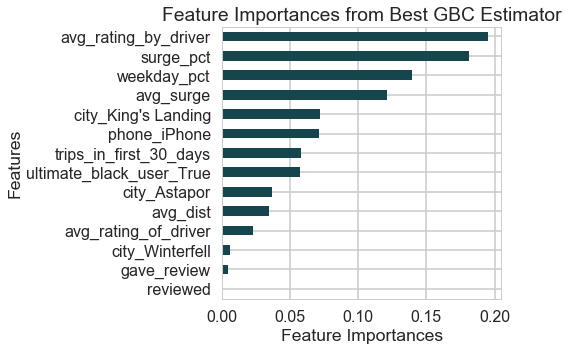

In [38]:
# Create df of Feature Importances of Best GBC Estimator
coeff = list(best_estimator.feature_importances_)
labels = list(X_train.columns)
features = pd.DataFrame()
features['Features'] = labels
features['Coefficients'] = coeff
features.sort_values(by=['Coefficients'], ascending=True, inplace=True)
features['positive'] = features['Coefficients'] > 0
features.set_index('Features', inplace=True)

#Plot Horizontal Bar Graph of Feature Importances
features['Coefficients'].plot(kind='barh', figsize=(5, 5),color = features.positive.map({True: palette[1], False: palette[4]}))
plt.title('Feature Importances from Best GBC Estimator')
plt.xlabel('Feature Importances')

plt.show()

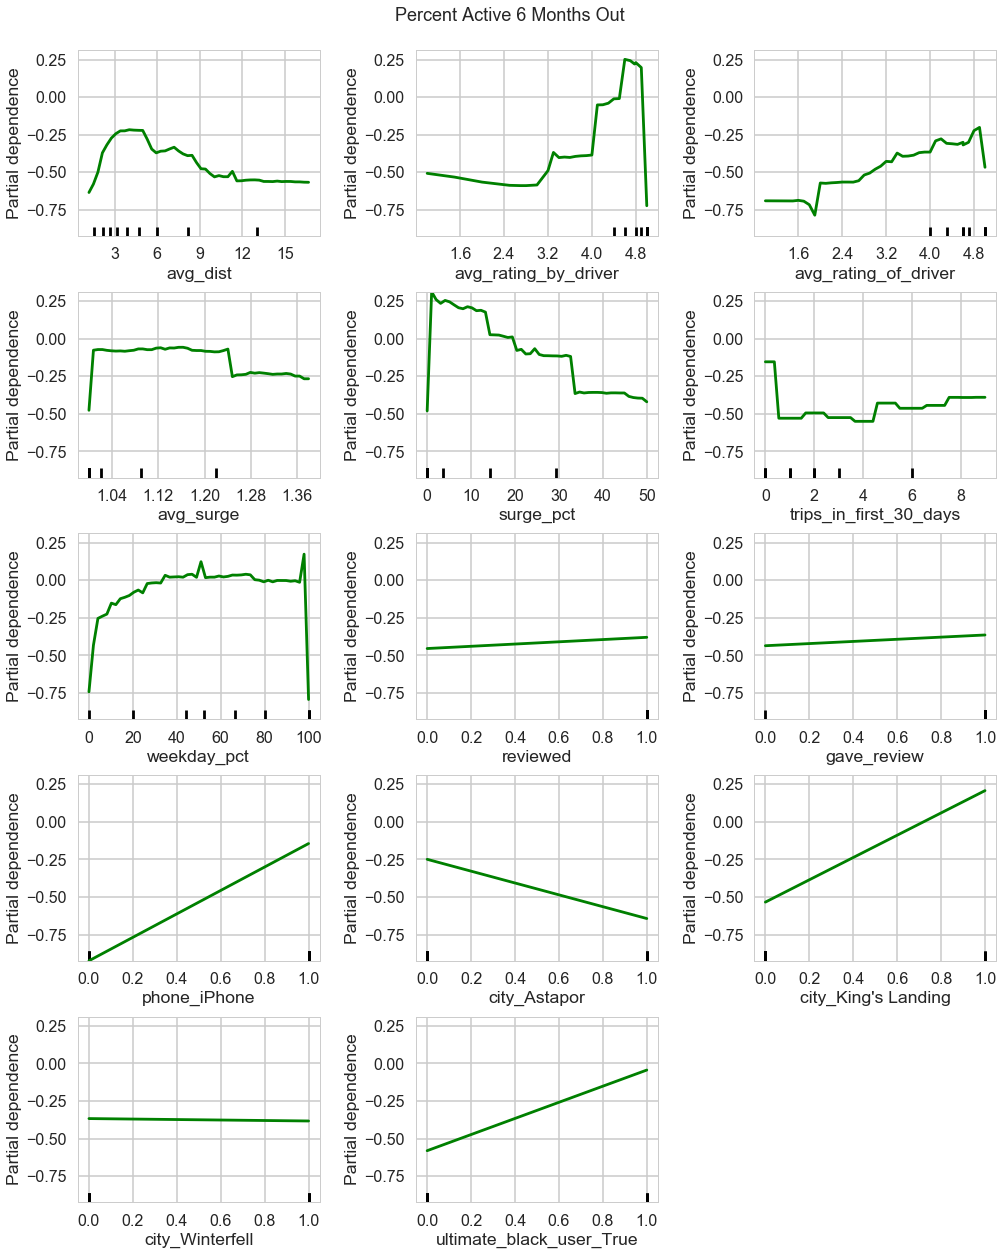

In [39]:
def main():
    names = list(X.columns.unique())

    features = range(len(names))
    fig, axs = plot_partial_dependence(best_estimator, X_train, features,
                                       feature_names=names,
                                       n_jobs=3, 
                                       grid_resolution=50,
                                       figsize = (15,20)
                                      )
    fig.suptitle('Percent Active 6 Months Out\n', fontsize=18)
    plt.subplots_adjust(top=0.95)  # tight_layout causes overlap with suptitle

    plt.show()

main()

## Observations and Recommendations
    1. Average rating by driver and of driver both seem to be important. It makes sense that customer satisfaction impacts retention, but it is interesting to see that driver satisfaction is related as well. Maybe customers who don't value and buy in to the service aren't good passengers.
    2. It seems like people who take shorter trips and mostly trips during the weekday (maybe customers using the service for commuting) tend to stay on the platform longer.
    3. Surge frequency seems to be more impactful than average surge. Maybe, to hold revenue constant, Ultimate should try to make surge pricing less frequent by simply raising pricing or raising priced more during surges.
    4. Those that take more trips in the first 30 days do tend to stay on the platform longer. It's hard to tell whether this is simply correlation or causation. Uber could try a test giving new users discounts on rides.
    5. It seems as is users with iPhones tend to stay on the app longer. Maybe for some reason this product's demographic matches Apple's rather than Android's forsome reason, or maybe the Andriod version of the Ultimate app is not as good as the Apple version of the app.